In [116]:
!pip install implicit rectools

In [117]:
import pandas as pd
import requests
from tqdm.auto import tqdm
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender
import warnings

from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models import PopularModel, RandomModel, ImplicitItemKNNWrapperModel, PopularInCategoryModel,EASEModel,ImplicitALSWrapperModel
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset import Dataset
from rectools.metrics import MeanInvUserFreq, AvgRecPopularity

from implicit.als import AlternatingLeastSquares


In [118]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...',
                        total=total_size_in_bytes,
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [119]:
!unzip kion_train.zip -x '__MACOSX/*'

Archive:  kion_train.zip
replace data_original/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace data_original/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [120]:
interactions = (
    pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={'total_dur': Columns.Weight,
                     'last_watch_dt': Columns.Datetime})
)
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

# ### ! если хотите быстро прогнать этот ноутбук - раскомментируйте эти строки - она уменьшает данные
# import numpy as np
# user_ids = np.random.choice(interactions.user_id.unique(), size=50000, replace=False)
# interactions = interactions[interactions.user_id.isin(user_ids)]
# ###

print(interactions.shape, interactions.user_id.nunique())
interactions.head()

(5476251, 5) 962179


,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


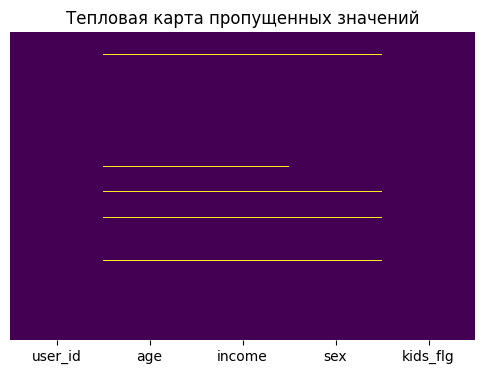

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(users.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [122]:
missing_percentage_users = users.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_users)

Процент пропущенных значений в каждой колонке:
user_id     0.000000
age         1.677583
income      1.758635
sex         1.646162
kids_flg    0.000000
dtype: float64


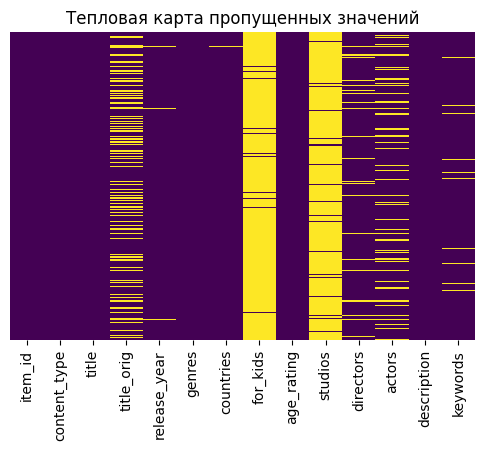

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(items.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [124]:
missing_percentage_items = items.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_items)

Процент пропущенных значений в каждой колонке:
item_id          0.000000
content_type     0.000000
title            0.000000
title_orig      29.724989
release_year     0.613920
genres           0.000000
countries        0.231786
for_kids        96.454301
age_rating       0.012529
studios         93.328322
directors        9.453110
actors          16.406690
description      0.012529
keywords         2.649878
dtype: float64


In [125]:
interactions.shape,items.shape,users.shape

((5476251, 5), (15963, 14), (840197, 5))

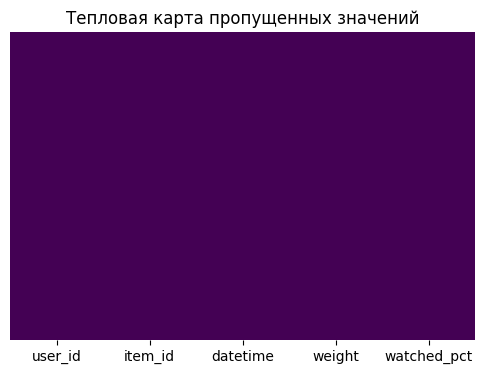

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(interactions.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [127]:
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (5051815, 5)
test: (306752, 5)


In [128]:
from rectools.dataset import Dataset

interactions_dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [129]:
# 1. Создаем PopularModel
pop_model = PopularModel() #popularity='n_interactions'
pop_model.fit(interactions_dataset)

In [130]:
# Предсказание топ 5 предметов для пользователя
user_id = [1]  # Пример ID пользователя
popular_items = pop_model.recommend(user_id, interactions_dataset,filter_viewed=False, k=10)
popular_items

,user_id,item_id,score,rank
0,1,10440,189923.0,1
1,1,15297,180487.0,2
2,1,9728,119797.0,3
3,1,13865,115095.0,4
4,1,4151,85914.0,5
5,1,3734,69687.0,6
6,1,2657,66415.0,7
7,1,4880,53191.0,8
8,1,142,42877.0,9
9,1,6809,39498.0,10


In [131]:
pop_model.get_params()

{'cls': rectools.models.popular.PopularModel,
 'verbose': 0,
 'popularity': <Popularity.N_USERS: 'n_users'>,
 'period': None,
 'begin_from': None,
 'add_cold': False,
 'inverse': False}

In [132]:
# Найти предметы с наибольшим score
# Сначала отсортируем по колонке 'score' в порядке убывания
highest_scored_items = popular_items.sort_values(by="score", ascending=False)

# Выведем предметы с максимальным score (весь список или, например, топ-1)
top_item = highest_scored_items.head(10)  # Для случая, когда нужен только один самый лучший предмет
print("Товар с наивысшим score:\n", top_item)

Товар с наивысшим score:
    user_id  item_id     score  rank
0        1    10440  189923.0     1
1        1    15297  180487.0     2
2        1     9728  119797.0     3
3        1    13865  115095.0     4
4        1     4151   85914.0     5
5        1     3734   69687.0     6
6        1     2657   66415.0     7
7        1     4880   53191.0     8
8        1      142   42877.0     9
9        1     6809   39498.0    10


In [133]:
pop_recs_1 = popular_items.merge(items[['item_id', 'title']],
                           on='item_id',
                           how='left')
pop_recs_1

,user_id,item_id,score,rank,title
0,1,10440,189923.0,1,Хрустальный
1,1,15297,180487.0,2,Клиника счастья
2,1,9728,119797.0,3,Гнев человеческий
3,1,13865,115095.0,4,Девятаев
4,1,4151,85914.0,5,Секреты семейной жизни
5,1,3734,69687.0,6,Прабабушка легкого поведения
6,1,2657,66415.0,7,Подслушано
7,1,4880,53191.0,8,Афера
8,1,142,42877.0,9,Маша
9,1,6809,39498.0,10,Дуров


In [134]:
pop_recs = pop_model.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

pop_recs = pop_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
pop_recs.head(20)

,user_id,item_id,score,rank,title
0,203219,10440,189923.0,1,Хрустальный
1,203219,15297,180487.0,2,Клиника счастья
2,203219,9728,119797.0,3,Гнев человеческий
3,203219,13865,115095.0,4,Девятаев
4,203219,4151,85914.0,5,Секреты семейной жизни
5,203219,3734,69687.0,6,Прабабушка легкого поведения
6,203219,2657,66415.0,7,Подслушано
7,203219,4880,53191.0,8,Афера
8,203219,142,42877.0,9,Маша
9,203219,6809,39498.0,10,Дуров


In [135]:
# популярность признаку genres
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head()

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы"
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы"


In [136]:
# делаем flatten представление фичи жанров
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [137]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]
genre_feature

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre


In [138]:
dataset_feature_pop = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

In [139]:
from rectools.models.popular_in_category import PopularInCategoryModel

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset_feature_pop);

In [ ]:
pop_recs_cat = pop_cat.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_pop,
    k=10,
    filter_viewed=False
)

In [ ]:
pop_recs_cat = pop_recs_cat.merge(items[['item_id', 'title']],
                                   on='item_id',
                                   how='left')

pop_recs_cat.head(10)

In [ ]:
model_ease = EASEModel(regularization=500)
model_ease.fit(interactions_dataset);

In [ ]:
ease_recs = model_ease.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

ease_recs = ease_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
ease_recs.head(10)

In [ ]:
model_iALS = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    ),
    fit_features_together=False,  # way to fit paired features
)
model_iALS.fit(interactions_dataset);

In [ ]:
iALS_recs = model_iALS.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs = iALS_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs.head(10)

In [ ]:
from rectools.metrics import (calc_metrics, MeanInvUserFreq,
                              AvgRecPopularity, MAP, NDCG, CoveredUsers,HitRate,
                              CatalogCoverage,Intersection,Serendipity)

recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    "ease_recs": ease_recs,
    'iALS_recs':iALS_recs
}

metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
    "ndcg": NDCG(k=10),
    "covarege": CoveredUsers(k=10),
    "hitrate": HitRate(k=10),
    "Intersection":Intersection(k=10),
    "Serendipity@10": Serendipity(k=10)

}

metrics_dict = {}
for model_name, recs_1 in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_1,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        # ref_reco=["popular"]
        ref_reco = {"same_model": recs_1}
    )


pd.DataFrame(metrics_dict).T

In [ ]:
def leave_top_k(reco, k):
    # Функция для выбора топ-K рекомендаций
    return reco[reco['rank'] <= k]

def coverage(reco, k, interactions, catalog):


    # Оставляем только топ-K рекомендации
    pred_to_consider = set(leave_top_k(reco, k)['item_id'].values)

    # Преобразуем полный каталог в множество
    all_items = set(catalog)

    # Вычисляем Coverage@K
    coverage_score = len(pred_to_consider & all_items) / len(all_items)
    return coverage_score


# Построим результаты Coverage@K для двух моделей
k = 10 # Задаем значение K
for model_name, model_recs in recs.items():

    cov_score = coverage(model_recs, k, None, train['user_id'].unique())
    print(f"Coverage@{k} для модели {model_name}: {cov_score:.2%}")

In [ ]:
import pandas as pd
import plotly.express as px
import re
from rectools.metrics import (
    calc_metrics, MeanInvUserFreq, AvgRecPopularity, MAP, NDCG, CoveredUsers,
    HitRate, CatalogCoverage, Intersection, Serendipity
)

# Рекомендации от разных моделей
recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    "ease_recs": ease_recs,
    "iALS_recs": iALS_recs,
}

# Метрики
metrics = {
    "MAP@10": MAP(k=10),              # Качество ранжирования
    "Novelty": MeanInvUserFreq(k=10), # Глобальная новизна
    "ARP": AvgRecPopularity(k=10),    # Bias к популярности
    "NDCG@10": NDCG(k=10),            # Нормализованная средневзвешенная кумулятивная прибыль
    "Coverage@10": CoveredUsers(k=10),# Покрытие пользователей
    "HitRate@10": HitRate(k=10),      # Процент пользователей, получивших хотя бы одну релевантную рекомендацию
    "Intersection@10": Intersection(k=10), # Пересечение рекомендаций
    "Serendipity@10": Serendipity(k=10),   # Серендипность рекомендаций
}

# Словарь для хранения результатов метрик
metrics_dict = {}

# Вычисляем метрики для каждой модели
for model_name, recs_model in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_model,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        ref_reco={"same_model": recs_model},
    )

# Преобразуем результат в DataFrame
cv_results = pd.DataFrame(metrics_dict).T

# Группируем результаты, если требуется
pivot_results = cv_results.groupby(level=0).mean()  # Группировка по моделям (уровень 0)
pivot_results.index.name="model"
# Выводим метрики только, которые нужны
models_metrics = pivot_results.reset_index()[["model","MAP@10", "Serendipity@10"]]

# Фильтрация моделей, которые нужно исключить
models_to_skip_meta = ["bert4rec_softmax_ids_and_cat"]


# Сегментация и сортировка (при необходимости)
models_metadata = [
    {
        "model": model_name,
        "item_net_block_types": ",".join(
            block for block in ["Id", "Cat"]
            if re.search(block, str(metrics_dict.get(model_name, {}).get("item_net_block_types", "")))
        ),
    }
    for model_name in recs.keys() if model_name not in models_to_skip_meta
]

# Вывод всех моделей и метрик для визуализации
from rectools.visuals import MetricsApp  # Импорт вашего MetricsApp

app = MetricsApp.construct(
    models_metrics=models_metrics,
    models_metadata=pd.DataFrame(models_metadata),
    scatter_kwargs={
        "color_discrete_sequence": px.colors.qualitative.Dark24,
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)

fig = app.fig
fig.update_layout(title="Model CV metrics with Serendipity", font={"size": 15})
fig.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()